## 1 : Curreny Coversion

##
These 2 usecase does not have any llm involved. Just for undestanding the Langgraph state, nodes, edges

In [2]:
from typing import TypedDict

class PortfolioState(TypedDict):
    amount_usd: float
    total_usd: float
    total_inr: float

In [3]:
def calc_total(state: PortfolioState): #-> PortfolioState:
    state['total_usd'] = state['amount_usd'] * 1.08
    return state

def convert_to_inr(state: PortfolioState): #-> PortfolioState:
    state['total_inr'] = state['total_usd'] * 90
    return state

In [4]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(PortfolioState)

builder.add_node("calc_total_node", calc_total)
builder.add_node("convert_to_inr_node", convert_to_inr)

builder.add_edge(START, "calc_total_node")
builder.add_edge("calc_total_node", "convert_to_inr_node")
builder.add_edge("convert_to_inr_node", END)

graph = builder.compile()

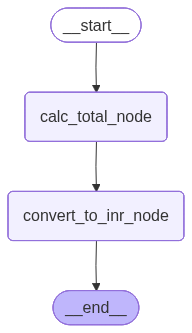

In [5]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
graph.invoke({"amount_usd": 100000})

{'amount_usd': 100000, 'total_usd': 108000.0, 'total_inr': 9720000.0}

## 2. Conditional edges.
For converting from `USD` to `INR` take one path. For converting to  `EUR` Follow different path.


In [7]:
from typing import TypedDict, Literal

class PortfolioState(TypedDict):
    amount_usd: float
    total_usd: float
    target_currency: Literal["INR", "EUR"]
    total: float

In [9]:
def calc_total(state: PortfolioState) -> PortfolioState:
    state['total_usd'] = state['amount_usd'] * 1.08
    return state

def convert_to_inr(state: PortfolioState) -> PortfolioState:
    state['total'] = state['total_usd'] * 90
    return state

def convert_to_eur(state: PortfolioState) -> PortfolioState:
    state['total'] = state['total_usd'] * 0.9
    return state

def choose_conversion(state: PortfolioState) -> str:
    return state["target_currency"]

In [10]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(PortfolioState)

builder.add_node("calc_total_node", calc_total)
builder.add_node("convert_to_inr_node", convert_to_inr)
builder.add_node("convert_to_eur_node", convert_to_eur)

builder.add_edge(START, "calc_total_node")
builder.add_conditional_edges(
    "calc_total_node",
    choose_conversion,
    {
        "INR": "convert_to_inr_node",
        "EUR": "convert_to_eur_node",
    }
)
builder.add_edge(["convert_to_inr_node", "convert_to_eur_node"], END)

graph = builder.compile()

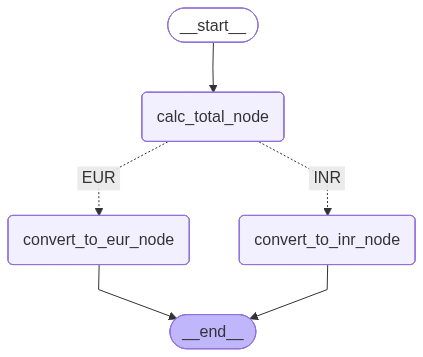

In [11]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
graph.invoke({"amount_usd": 1000, "target_currency": "EUR"})

{'amount_usd': 1000,
 'total_usd': 1080.0,
 'target_currency': 'EUR',
 'total': 972.0}